# Local Differential Privacy (LDP) - Test practic

Acest notebook arata cum se aplica Local DP pe un set de date simplu (ex. Titanic).  
Se foloseste functia encode_local_dp() care adauga zgomot Laplace local pe fiecare instanta. Acest notebook arata cum se aplica Local Differential Privacy (LDP) pe un set de date simplu (ex. Titanic). Se foloseste functia encode_local_dp() care adauga zgomot Laplace local pe fiecare inregistrare. Experimentul calculeaza numarul persoanelor cu varsta peste 50 de ani si arata cum variaza rezultatul in functie de valoarea epsilon aleasa, evidentiind eroarea introdusa de mecanismul de protectie.

📊 Valoare reala COUNT(Age > 50): 72
   epsilon  rezultat_ldp       eroare      status
0     0.01  -6318.136580  6390.136580     respins
1     0.05     68.297747     3.702253  acceptabil
2     0.10    378.417991   306.417991     respins
3     0.20    217.487271   145.487271     respins
4     0.50      6.890100    65.109900     respins
5     0.70    142.697687    70.697687     respins
6     1.00     65.992171     6.007829     aproape
7     2.00     68.036343     3.963657  acceptabil
8     3.00     87.424245    15.424245     respins
9     5.00     59.950960    12.049040     respins


C:\Users\pirjo\AppData\Local\Temp\ipykernel_32500\1334290149.py:83: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pirjo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pirjo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


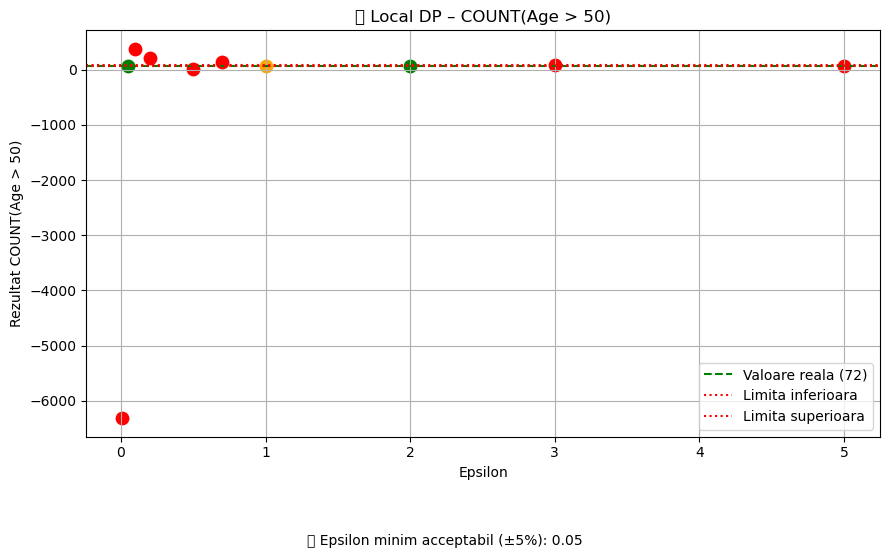

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === PAS 1: Încarcă și sparge coloana unică ===
df_raw = pd.read_excel("titanic.xlsx")
df = df_raw.iloc[:, 0].str.split(",", expand=True)

# === PAS 2: Setează headerul manual ===
df.columns = [
    "Survived", "Pclass", "Name", "Sex", "Age",
    "Siblings/Spouses Aboard", "Parents/Children Aboard", "Fare"
]

# === PAS 3: Extrage și curăță coloana Age ===
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
ages = df["Age"].dropna().tolist()

# === PAS 4: Parametri reali și interval acceptabil ===
valoare_real = sum([age > 50 for age in ages])
interval_strict = (valoare_real - 4, valoare_real + 4)
interval_larg = (valoare_real * 0.90, valoare_real * 1.10)

print(f"📊 Valoare reala COUNT(Age > 50): {valoare_real}")

# === PAS 5: Functie LDP
def encode_local_dp(value, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    return value + np.random.laplace(0.0, scale)

# === PAS 6: Rulare pe epsilon-uri
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 3.0, 5.0]
rezultate = []

for eps in epsilons:
    encoded = [encode_local_dp(1.0 if age > 50 else 0.0, eps) for age in ages]
    count_ldp = sum(encoded)
    eroare = abs(count_ldp - valoare_real)
    
    if interval_strict[0] <= count_ldp <= interval_strict[1]:
        status = 'acceptabil'
    elif interval_larg[0] <= count_ldp <= interval_larg[1]:
        status = 'aproape'
    else:
        status = 'respins'
    
    rezultate.append({
        "epsilon": eps,
        "rezultat_ldp": count_ldp,
        "eroare": eroare,
        "status": status
    })

# === PAS 7: Tabel + grafice pe culori ===
df_ldp = pd.DataFrame(rezultate)
print(df_ldp)

plt.figure(figsize=(9,5))

for index, row in df_ldp.iterrows():
    color = {'acceptabil': 'green', 'aproape': 'orange', 'respins': 'red'}[row['status']]
    plt.scatter(row['epsilon'], row['rezultat_ldp'], color=color, s=80)

plt.axhline(y=valoare_real, color='green', linestyle='--', label=f"Valoare reala ({valoare_real})")
plt.axhline(y=interval_strict[0], color='red', linestyle=':', label="Limita inferioara")
plt.axhline(y=interval_strict[1], color='red', linestyle=':', label="Limita superioara")
plt.xlabel("Epsilon")
plt.ylabel("Rezultat COUNT(Age > 50)")
plt.title("🔒 Local DP – COUNT(Age > 50)")
plt.grid(True)
plt.legend()

# === PAS 8: Text explicativ
acceptabili = df_ldp[df_ldp["status"] == "acceptabil"]
if not acceptabili.empty:
    min_eps = acceptabili["epsilon"].min()
    plt.gcf().text(0.5, -0.1, f"✅ Epsilon minim acceptabil (±5%): {min_eps}", 
                   ha='center', fontsize=10, color='black')
else:
    plt.gcf().text(0.5, -0.1, "❌ Niciun epsilon nu ofera un rezultat acceptabil (±5%)", 
                   ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

